# Automatic computation of Cramer-Rao Lower Bound using the `chirho.robust` module

## Cramer-Rao Lower Bound

**Theorem  (Cramer-Rao Lower Bound - Vector Parameter)**
(Theorem 3.2 in [1])

It is assumed that the PDF $p(\mathbf{x} ; \boldsymbol{\theta})$ satisfies the "regularity" conditions

$$
E\left[\frac{\partial \ln p(\mathbf{x} ; \boldsymbol{\theta})}{\partial \boldsymbol{\theta}}\right]=\mathbf{0} \quad \text { for all } \boldsymbol{\theta}
$$

where the expectation is taken with respect to $p(\mathbf{x} ; \boldsymbol{\theta})$. Then, the covariance matrix of any unbiased estimator $\hat{\boldsymbol{\theta}}$ satisfies

$$
\mathbf{C}_{\tilde{\theta}}-\mathbf{I}^{-1}(\theta) \geq 0
$$

where $\geq 0$ is interpreted as meaning that the matrix is positive semidefinite. The Fisher information matrix $\mathbf{I}(\boldsymbol{\theta})$ is given as

$$
[\mathbf{I}(\boldsymbol{\theta})]_{i j}=-E\left[\frac{\partial^2 \ln p(\mathbf{x} ; \boldsymbol{\theta})}{\partial \theta_i \partial \theta_j}\right]
$$

where the derivatives are evaluated at the true value of $\boldsymbol{\theta}$ and the expectation is taken with respect to $p(\mathbf{x} ; \boldsymbol{\theta})$. Furthermore, an unbiased estimator may be found that attains the bound in that $\mathbf{C}_{\hat{\theta}}=\mathbf{I}^{-1}(\boldsymbol{\theta})$ if and only if

$$
\frac{\partial \ln p(\mathbf{x} ; \boldsymbol{\theta})}{\partial \boldsymbol{\theta}}=\mathbf{I}(\boldsymbol{\theta})(\mathbf{g}(\mathbf{x})-\boldsymbol{\theta})
$$

for some $p$-dimensional function $\mathbf{g}$ and some $p \times p$ matrix $\mathbf{I}$. That estimator, which is the MVU estimator, is $\hat{\boldsymbol{\theta}}=\mathbf{g}(\mathbf{x})$, and its covariance matrix is $\mathbf{I}^{-1}(\boldsymbol{\theta})$.

[1] S. Kay, Fundamentals of Statistical Signal Processing, Volume I: Estimation Theory, 1 edition. Englewood Cliffs, N.J: Prentice Hall, 1993.

## CRLB and influence functions

Notice that $\mathbf{I}(\boldsymbol{\theta})$ is exactly what appears in the definition of the parametric EIF in Eq.(1) in [2]:
\begin{align*}
\varphi_{\phi}(\tilde{x})&:=\left[\nabla_\phi \psi(\phi)\right]^T I(\phi)^{-1} \nabla_\phi \log p_\phi(\tilde{x}),\\
I(\phi)&:=\mathbb{E}_{x \sim p_\phi(x)}\left[\nabla_\phi \log p_\phi(x) \nabla_\phi \log p_\phi(x)^T\right]
\end{align*}


`chirho.robust` implements the Monte-Carlo EIF given by Eq.(2) in [2]:
$$
\hat{\varphi}_{\phi, M}(\tilde{x}):=\left[\nabla_\phi \hat{\psi}_M(\phi)\right]^T \hat{I}_M(\phi)^{-1} \nabla_\phi \log p_\phi(\tilde{x}).
$$
Notice that we have:
$$
\operatorname{var}\varphi_{\phi}(\tilde{x}) = \left[\nabla_\phi \psi(\phi)\right]^T I(\phi)^{-1} \left[\nabla_\phi \psi(\phi)\right].
$$

So for example the diagonal elements of $I(\phi)$ can be approximated by defining a trivial estimator $\psi_{\phi}(\tilde{x}):=\phi$, generating the samples of $\tilde{x}$ from the distribution $p_{\phi}$ and computing the variance of the MC-EIF.

[2] R. Agrawal, S. Witty, A. Zane, and E. Bingham, “Automated Efficient Estimation using Monte Carlo Efficient Influence Functions,” Mar. 08, 2024, arXiv: arXiv:2403.00158. doi: 10.48550/arXiv.2403.00158.


## Quick and dirty implementation

We shall consider the example from [1,Example 3.5]: Sinusoidal Frequency Estimation.

The likelihood model is given by

$$
s\left[n ; f_0\right]=\cos \left(2 \pi f_0 n\right) + w_n \quad 0<f_0<\frac{1}{2},
$$
where $w_n \sim \mathcal{N}(0,\sigma^2)$.

The Signal-to-Noise Ratio (SNR) is defined as
$$
\operatorname{SNR}:=\frac{1}{\sigma^2}.
$$

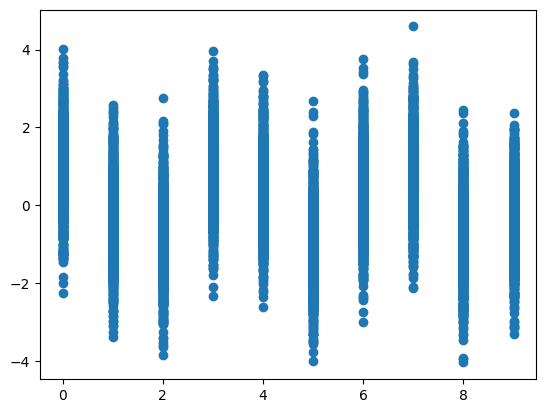

In [18]:
import pyro
import torch
import pyro.distributions as dist
import matplotlib.pyplot as plt

pyro.settings.set(module_local_params=True) # why? because

class SinusoidalModel(pyro.nn.PyroModule):
    def __init__(self, f0, N=10, snr=1.0):
        super().__init__()
        self.f0 = torch.nn.Parameter(torch.tensor(f0))
        self.n_vec = torch.arange(N)
        self.N = N
        self.snr = snr

    def forward(self):
        return pyro.sample("s", dist.Normal(torch.cos(2*torch.pi * self.f0 * self.n_vec), 1.0/self.snr).to_event(1))

N = 10
f0 = 0.3
sigma = 1.0
model = SinusoidalModel(f0=f0,N=N,snr=1.0/sigma)

num_monte_carlo = 1000
predictive = pyro.infer.Predictive(model,num_samples=num_monte_carlo, return_sites=["s"])

points = predictive()
plt.scatter(model.n_vec.expand(num_monte_carlo,-1).numpy(),points["s"].detach().numpy())
plt.show()
    

In [19]:
class TrivialFunctional(torch.nn.Module):
    def __init__(self, model : SinusoidalModel):
        super().__init__()
        self.model = model
        
    def forward(self):
        return self.model.f0
    
TrivialFunctional(model)()

Parameter containing:
tensor(0.3000, requires_grad=True)

In [20]:
from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator
from chirho.robust.ops import influence_fn

influence = influence_fn(
    TrivialFunctional,
    points,
)(model)

with MonteCarloInfluenceEstimator(num_samples_inner=100, num_samples_outer=100):
    with torch.no_grad():  # Avoids memory leak (see notes below)
        ii=influence()

ii.shape

torch.Size([1000])

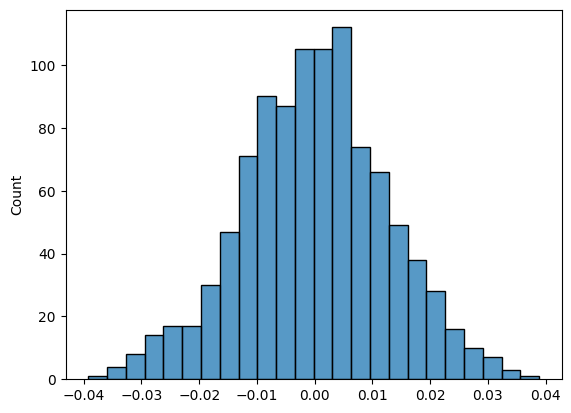

In [21]:
import seaborn as sns
sns.histplot(ii)
plt.show()

In [22]:
ii.std()

tensor(0.0127)

In [37]:
from tqdm import tqdm

f0_vec = torch.linspace(0.05,0.45,200)
res_vec = []
num_samples_inner = 10000
num_samples_outer = 10000

for f0 in tqdm(f0_vec):
    model.f0.data = f0
    points = predictive()
    influence = influence_fn(
        TrivialFunctional,
        points,
    )(model)
    with MonteCarloInfluenceEstimator(num_samples_inner=num_samples_inner, num_samples_outer=num_samples_outer):
        with torch.no_grad():  # Avoids memory leak 
            ii=influence()
    res_vec.append(torch.mean(ii**2).item())



100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


The analytical CRLB is given by

$$
\operatorname{var}\left(\hat{f}_0\right) \geq \frac{\sigma^2}{A^2 \sum_{n=0}^{N-1}\left[2 \pi n \sin \left(2 \pi f_0 n\right)\right]^2}.
$$

In [107]:
# the analytic CRB
def CRLB_analytic(f0):
    return sigma**2/(
        (2*torch.pi*model.n_vec.expand(f0.shape[0],-1)* \
            torch.sin(2*torch.pi*f0.unsqueeze(-1)*model.n_vec.unsqueeze(-2)
                      )
            )**2
            ).sum(axis=1)


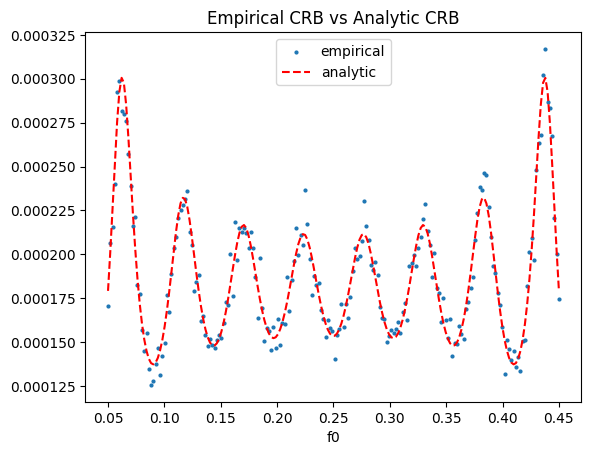

In [110]:
plt.scatter(f0_vec,torch.tensor(res_vec),s=4,label="empirical")
plt.plot(f0_vec,CRLB_analytic(f0_vec),color="red", linestyle="--",label="analytic")
plt.legend()
plt.xlabel("f0")
plt.title("Empirical CRB vs Analytic CRB")
plt.show()

## Task

We would like to implement this more efficiently, without sampling a lot of points.